<a href="https://colab.research.google.com/github/atfrank/CS-Annotate/blob/master/Structural_Annotation_of_RNA_Using_NMR_Chemical_Shifts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Structural Annotation of RNA Using NMR Chemical Shifts

# TODO:

1. Confirm no leakage of features into the training sets
2. Confirm that there is no overlap between training and testing set
3. Implement compact workflow to test accuracy of model Explore DeepChem model class
4. Implement student models and use them as baseline comparison model. Will present them in the supporting information

# Manuscript Sketch

* **Introduction**:

1. RNA structure important
2. NMR probes structure
3. Chemical shifts in particular sensitive to structure
4. Highlight examples of structural parameters extracted from chemical shift data
5. Introduce the idea of structural annotation via NMR chemical shifts
  * base pairs
  * adjacent and non-adjacent stacking
  * syn vs. anti
  * solvent exposure
  * [pucker](https://www.youtube.com/watch?v=4VQxRKQcMYg)

6. Survey the use of machine learning used to predict structural parameter from NMR chemical shifts, for both proteins and RNA
7. Make point that most approaches previous approaches employed single task learning
8. Extol the virtues of multi-task learning
10. Summarize what we did and the results

* **Methods**:
1. Data set
2. MC-Annotate
3. Multi-task classifiers

* **Results**:
1. Model performance on test set (Macro-Analysis: e.g., ROC and concordance analysis) including impact of number of neighbors
2. Model performance on test set (Micro-Analysis); Compare, visually target and prediction, highlighting (and possibly explaning) errors.
3. Importance analysis (which chemical shifts are important for predicting each structural feature)




# Initialization

In [1]:
!apt-get -qq install -y python-rdkit librdkit1 rdkit-data

Selecting previously unselected package fonts-freefont-ttf.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../fonts-freefont-ttf_20120503-7_all.deb ...
Unpacking fonts-freefont-ttf (20120503-7) ...
Selecting previously unselected package librdkit1.
Preparing to unpack .../librdkit1_201603.5+dfsg-1ubuntu1_amd64.deb ...
Unpacking librdkit1 (201603.5+dfsg-1ubuntu1) ...
Selecting previously unselected package rdkit-data.
Preparing to unpack .../rdkit-data_201603.5+dfsg-1ubuntu1_all.deb ...
Unpacking rdkit-data (201603.5+dfsg-1ubuntu1) ...
Selecting previously unselected package python-rdkit.
Preparing to unpack .../python-rdkit_201603.5+dfsg-1ubuntu1_amd64.deb ...
Unpacking python-rdkit (201603.5+dfsg-1ubuntu1) ...
Setting up rdkit-data (201603.5+dfsg-1ubuntu1) ...
Setting up fonts-freefont-ttf (20120503-7) ...
Setting up librdkit1 (201603.5+dfsg-1ubuntu1) ...
Setting up python-rdkit (201603.5+dfsg-1ubuntu1) ...
Processing triggers for libc-bi

In [2]:
!pip install -q joblib sklearn tensorflow pillow deepchem

     |████████████████████████████████| 3.9MB 2.8MB/s 
     |████████████████████████████████| 512kB 48.5MB/s 


In [3]:
# test
import rdkit as rd
import deepchem as dc
import numpy as np
import tensorflow as tf
import pandas as pd 


W0129 02:27:12.343940 139981174069120 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
NUMBER_CHEMICAL_SHIFT_TYPE = 19
RETAIN = ['id', 'resid', 'resname', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All', 'sasa', 'syn_anti', 'astack', 'nastack', 'pair', 'pucker', 'class']
RETAIN_NONAME = ['id', 'resid', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All', 'sasa', 'syn_anti', 'astack', 'nastack', 'pair', 'pucker', 'class']

def get_cs_all(cs_all, id):
	'''
	This function gets chemical shifts for a particular RNA.
	'''
	return(cs_all[cs_all.id == id])

def get_cs_residues(cs_i, resid, dummy=0):
	'''
	This function return an array contining the chemical shifts 
	for a particular residues in an RNA.
	'''
	cs_tmp=cs_i[(cs_i.resid == resid)].drop(RETAIN, axis=1)
	info_tmp=cs_i[(cs_i.resid == resid)]
	if (cs_tmp.shape[0] != 1):
		return(dummy*np.ones(shape=(1, NUMBER_CHEMICAL_SHIFT_TYPE)))
	else:
		return(cs_tmp.values)

def get_resnames(cs_i, resid, dummy="UNK"):
	'''
	This function returns the residue name for specified residue (resid)
	'''
	cs_tmp=cs_i[(cs_i.resid == resid)]
	if (cs_tmp.shape[0] != 1):
		return(dummy)
	else:
		return(cs_tmp['resname'].values[0])

def get_cs_features(cs_i, resid, neighbors):
	'''
	This function return chemical shifts and resnames for 
	residues (resid) and its neighbors
	'''
	cs=[]
	resnames=[]
	for i in range(resid-neighbors, resid+neighbors+1):
		cs.append(get_cs_residues(cs_i, i))
		resnames.append(get_resnames(cs_i, i))
	return(resnames, np.array(cs))

def get_columns_name(neighbors=3, chemical_shift_types = NUMBER_CHEMICAL_SHIFT_TYPE):
	'''
	Helper function that writes out the required column names
	'''
	#tmp=2*neighbors+1
	#neighbors=1
	columns=RETAIN
	for i in range(0, neighbors*NUMBER_CHEMICAL_SHIFT_TYPE):
		columns.append(i)
	return(columns)

def write_out_resname(neighbors=1):
	''' 
	Helper function that writes out the column names associated 
	resnames for a given residue and its neighbors
	'''  
	colnames = []
	for i in range(1-neighbors-1, neighbors+1):
		if i < 0: 
			colnames.append('R%s'%i)
		elif i > 0: 
			colnames.append('R+%s'%i)
		else: 
			colnames.append('R')
	return(colnames)    

def get_cs_features_rna(cs, neighbors=1):
	'''    
	This function generates the complete required data frame an RNA    
	'''
	all_features = []
	all_resnames = []
	for resid in cs['resid'].unique():
		resnames, features = get_cs_features(cs, resid, neighbors)
		all_features.append(features.flatten())
		all_resnames.append(resnames)

	all_resnames = pd.DataFrame(all_resnames, dtype='object', columns = write_out_resname(neighbors))
	all_features = pd.DataFrame(all_features, dtype='object')
	info = pd.DataFrame(cs[RETAIN_NONAME].values, dtype='object', columns = RETAIN_NONAME)
	return(pd.concat([info, all_resnames, all_features], axis=1))

def get_cs_features_rna_all(cs, neighbors):  
	'''    
	This function generate a pandas dataframe containing training data for all RNAs
	Each row in the data frame should contain the class and chemical shifts for given residue and neighbors in a given RNA.
	'''  
	cs_new=pd.DataFrame()
	for pdbid in cs['id'].unique()[0 :]:
		tmp=get_cs_features_rna(get_cs_all(cs, id=pdbid), neighbors)
		cs_new=pd.concat([cs_new, tmp], axis=0)
	return(cs_new)
 
def one_hot_encode(df, hot_columns):
  '''
    This function generate one hot encodes a dataFrame
    see: http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example 
  '''
  for hot_column in hot_columns:
    # use pd.concat to join the new columns with your original dataframe
    df = pd.concat([df, pd.get_dummies(df[hot_column], prefix=hot_column)],axis=1)
    # now drop the original 'country' column (you don't need it anymore)
    df.drop([hot_column],axis=1, inplace=True)
  return(df)

def balance_transformer(dataset):
    '''
      Copy of deepchem function for reweighting samples. 
      Deepchem version does not work.
    '''
    # Compute weighting factors from dataset.
    y = dataset.y
    w = dataset.w
    # Ensure dataset is binary
    np.testing.assert_allclose(sorted(np.unique(y)), np.array([0., 1.]))
    weights = []
    for ind, task in enumerate(dataset.get_task_names()):
      task_w = w[:]
      task_y = y[:]
      # Remove labels with zero weights
      task_y = task_y[task_w != 0]
      num_positives = np.count_nonzero(task_y)
      num_negatives = len(task_y) - num_positives
      if num_positives > 0:
        pos_weight = float(num_negatives) / num_positives
      else:
        pos_weight = 1
      neg_weight = 1
      weights.append((neg_weight, pos_weight)) 
    return(dc.data.NumpyDataset(X=dataset.X, y=dataset.y, w=np.where(y==1, pos_weight, neg_weight)))

def get_training_data(neighbors):
  url="https://drive.google.com/uc?id=1ARcR1TVkG-X3BN8yUnW0WWRUHC9-ye_K&authuser=afrankz@umich.edu&usp=drive_fs"
  s=requests.get(url).content
  c=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = "\s+")
  cs_data = c.rename(columns = {'H8\t' : 'H8'})
  if 'Unnamed: 0' in cs_data.columns:
    cs_data = cs_data.drop(columns = ['Unnamed: 0'])

  cs_all = get_cs_features_rna_all(cs_data, neighbors = neighbors)
  cs_all = one_hot_encode(cs_all, write_out_resname(neighbors))
  return(cs_all)

def get_data(neighbors, training = True):
  # load sasa data
  if training:    
    url="https://drive.google.com/uc?id=1Y3Imx-lTjGKCQAFqEKTbaMSzFARtwEFN&authuser=afrankz@umich.edu&usp=drive_fs"
  else:   
    url="https://drive.google.com/uc?id=1jLcowU89y4o5Xmv_qBs3VgZre5ZFFYwG&authuser=afrankz@umich.edu&usp=drive_fs"

  s=requests.get(url).content
  sasa=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = "\s+")
  print("[INFO]: SASA loaded data")
  print(sasa.head())

  # load cs data
  url="https://drive.google.com/uc?id=1ApGAKHnzKUjri-f_sSPZwqK5N3Cr7gPq&authuser=afrankz@umich.edu&usp=drive_fs"
  s=requests.get(url).content
  cs=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = " ")
  print("[INFO]: CS loaded data")
  print(cs.head())

  # load MC-Annotate
  url="https://drive.google.com/uc?id=1AY2tuleA7Q2yy5ID_YygIKPo2kR3EEH4&authuser=afrankz@umich.edu&usp=drive_fs"
  s=requests.get(url).content
  mc_anontate=pd.read_csv(io.StringIO(s.decode('utf-8')), sep = " ")
  print("[INFO]: MC-Annotate loaded data")

  # merge sasa and cs
  data = pd.merge(cs, sasa, on=['id', 'resname', 'resid'])
  # merge with mc-annotate structure
  data = pd.merge(data, mc_anontate, on=['id', 'resname', 'resid'])  
  drop_names = ['sugar_puckering', 'pseudoknot', 'junk']
  #data = data.drop(drop_names, axis=1)
  print("[INFO]: merged SASA, CS, and MC-Annotate")
  print(data.head())

  # prepare for testing
  print(data.columns)
  data_all = get_cs_features_rna_all(data, neighbors = neighbors)
  print("[INFO]: Prepared final data set")
  print(data_all.head())

  data_all = one_hot_encode(data_all, write_out_resname(neighbors))
  print("[INFO]: One-hot encoded data")
  print(data_all.head())
  return(data_all)


# Train Model

In [0]:
## Import Module
import pandas as pd
import numpy as np
import io
import pandas as pd
import io
import requests
import deepchem as dc
import tensorflow as tf

In [6]:
################################################################
## Prepare data
################################################################
neighbors = 3
train = get_data(neighbors, training = True)
test = get_data(neighbors, training = False)

[INFO]: SASA loaded data
     id resname  resid  ...  sasa-Main-Chain  sasa-Non-polar  sasa-All
0  1A60     GUA      1  ...            60.23           31.95    102.20
1  1A60     GUA      2  ...           115.09           38.57    133.43
2  1A60     GUA      3  ...           128.68           52.70    134.89
3  1A60     ADE      4  ...           130.26           57.02    129.43
4  1A60     GUA      5  ...           116.62           37.60    166.72

[5 rows x 8 columns]
[INFO]: CS loaded data
     id  resid resname   C1p   C2p   C3p  ...     H5   H5p  H5pp     H6    H8  class
0  1A60      1     GUA  92.7  74.9  72.0  ...  6.124  4.07  3.99  8.413  8.03      0
1  1A60      2     GUA  91.9  75.7  72.4  ...  5.549  4.20  4.15  7.871  7.49      0
2  1A60      3     GUA  92.2  76.1  72.3  ...  5.651  4.10  4.08  7.904  7.24      0
3  1A60      4     ADE  92.2  75.0  72.0  ...  5.932  4.28  4.11  8.413  7.68      0
4  1A60      5     GUA  92.2  74.8  71.8  ...  5.988  4.18  4.07  8.522  7.00  

In [0]:
# Prepare training set
sd_scale = 0.5
targets = ['sasa', 'astack',  'nastack', 'pair', 'syn_anti']
drop_names = ['id', 'resid', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All', 'sasa', 'astack',  'nastack', 'pair', 'syn_anti', 'pucker', 'class']
tmp_trainX = train.drop(drop_names, axis=1)
tmp_trainy = pd.DataFrame(train[targets].values, dtype = 'float', columns = targets)
trainX = pd.DataFrame(tmp_trainX.values, dtype = 'float')
trainy = tmp_trainy.values
train_mean = [trainy[:, 0].mean()]
train_sd = [sd_scale*np.std(trainy[:, 0])]
tmp = one_hot_encode(pd.DataFrame(train['pucker'].values, columns=['pucker']), ['pucker'])
trainy_mix = np.vstack([ np.where(trainy[:, 0] <= train_mean[0]+train_sd[0], 0, 1),                         
                        trainy[:, 1],
                        trainy[:, 2],
                        trainy[:, 3],
                        trainy[:, 4],
                        tmp['pucker_C2p_endo'].values,
                        tmp['pucker_C3p_endo'].values,
                        tmp['pucker_C2p_exo'].values,
                        tmp['pucker_C3p_exo'].values,
                        tmp['pucker_C1p_exo'].values,
                        tmp['pucker_C4p_exo'].values
                        ]).T
w = np.ones(len(trainy[:, 0]))
train_w = np.vstack([w, w, w, w, w, w, w, w, w, w, w]).T
train_dataset = dc.data.NumpyDataset(trainX, trainy_mix, train_w)

# Prepare test model
retain = ['id', 'resid', 'sasa']
tmp_testX = test.drop(drop_names, axis=1)
tmp_testy = pd.DataFrame(test[targets].values, dtype = 'float', columns = targets)
targets.append('pucker_C2p_endo')
targets.append('pucker_C3p_endo')
targets.append('pucker_C2p_exo')
targets.append('pucker_C3p_exo')
targets.append('pucker_C1p_exo')
targets.append('pucker_C4p_exo')

testX = pd.DataFrame(tmp_testX.values, dtype = 'float')
testy = tmp_testy.values
tmp = one_hot_encode(pd.DataFrame(test['pucker'].values, columns=['pucker']), ['pucker'])
testy_mix = np.vstack([ np.where(testy[:, 0] <= train_mean[0]+train_sd[0], 0, 1),                         
                        testy[:, 1],
                        testy[:, 2],
                        testy[:, 3],
                        testy[:, 4],
                        tmp['pucker_C2p_endo'].values,
                        tmp['pucker_C3p_endo'].values,
                        tmp['pucker_C2p_exo'].values,
                        tmp['pucker_C3p_exo'].values,
                        tmp['pucker_C1p_exo'].values,
                        tmp['pucker_C4p_exo'].values                       
                        ]).T
w = np.ones(len(testy[:, 0]))
test_w = np.vstack([w, w, w, w, w, w, w, w, w, w, w]).T
test_dataset = dc.data.NumpyDataset(np.array(testX), np.array(testy_mix), test_w)
info = pd.DataFrame(test[retain].values, dtype='object', columns = retain)
actuals = pd.DataFrame(testy_mix, columns=targets)


In [0]:
pd.DataFrame({"sasa":trainy_mix[:, 0], 
             "astack":trainy_mix[:, 1], 
             "nastack":trainy_mix[:, 2], 
             "pair":trainy_mix[:, 3], 
             "syn_anti":trainy_mix[:, 4], 
             "pucker_C2p_endo":trainy_mix[:, 5],
             "pucker_C3p_endo":trainy_mix[:, 6],
             "pucker_C2p_exo":trainy_mix[:, 7],
             "pucker_C3p_exo":trainy_mix[:, 8],
             "pucker_C1p_exo":trainy_mix[:, 9],
             "pucker_C4p_exo":trainy_mix[:, 10]}).to_csv("train_target.csv", sep = " ", index = False)

trainX.to_csv("train_features.csv", sep = " ", index = False)

pd.DataFrame({"sasa":testy_mix[:, 0], 
             "astack":testy_mix[:, 1], 
             "nastack":testy_mix[:, 2], 
             "pair":testy_mix[:, 3], 
             "syn_anti":testy_mix[:, 4], 
             "pucker_C2p_endo":testy_mix[:, 5],
             "pucker_C3p_endo":testy_mix[:, 6],
             "pucker_C2p_exo":testy_mix[:, 7],
             "pucker_C3p_exo":testy_mix[:, 8],
             "pucker_C1p_exo":testy_mix[:, 9],
             "pucker_C4p_exo":testy_mix[:, 10]}).to_csv("test_target.csv", sep = " ", index = False)

testX.to_csv("test_features.csv", sep = " ", index = False)

In [0]:
# Scale
transform_scaler = dc.trans.transformers.NormalizationTransformer(transform_X = True, transform_y = False, dataset=train_dataset)
train_dataset_norm = transform_scaler.transform(train_dataset)
test_dataset_norm = transform_scaler.transform(test_dataset)

# Balance Dataset
transform_balancer = dc.trans.transformers.BalancingTransformer(transform_w = True, dataset=train_dataset_norm)

#train_dataset_balanced = balancer.transform(train_dataset_norm)
train_dataset_balanced = balance_transformer(train_dataset_norm)

# confirm not overlap between between training and testing
set(train.id.unique()).intersection(set(test.id.unique()))

n_features = train_dataset_balanced.X.shape[1]
n_tasks = train_dataset_balanced.y.shape[1]

In [0]:
model = dc.models.ProgressiveMultitaskClassifier(n_tasks=n_tasks, n_features=n_features, alpha_init_stddevs=0.04)
model.fit(train_dataset_balanced, nb_epoch=100)

W0103 05:27:21.613854 140638720210816 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/progressive_multitask.py:208: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0103 05:27:21.712285 140638720210816 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/tensor_graph.py:715: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0103 05:27:21.721410 140638720210816 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/layers.py:2464: The name tf.FIFOQueue is deprecated. Please use tf.queue.FIFOQueue instead.

W0103 05:27:21.728049 140638720210816 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/deepchem/models/tensorgraph/layers.py:1216: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0103 05:27:21.75090

# Test Model

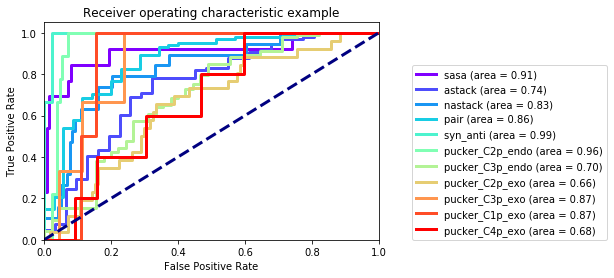

,id,resid,sasa,sasa,astack,nastack,pair,syn_anti,pucker_C2p_endo,pucker_C3p_endo,pucker_C2p_exo,pucker_C3p_exo,pucker_C1p_exo,pucker_C4p_exo,psasa,pastack,pnastack,ppair,psyn_anti,ppucker_C2p_endo,ppucker_C3p_endo,ppucker_C2p_exo,ppucker_C3p_exo,ppucker_C1p_exo,ppucker_C4p_exo
132,5KH8,43,183.51,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.380667,0.956079,0.000001,0.964696,9.012440e-07,0.004082,0.806172,0.078701,5.540427e-06,7.119557e-14,0.514702
133,5KH8,44,180.49,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.580960,0.764324,0.000589,0.843177,9.298865e-08,0.018362,0.638183,0.210536,3.784087e-06,4.377212e-11,0.534724
134,5KH8,45,163.27,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.349365,0.883506,0.005220,0.979564,1.003267e-15,0.000676,0.849100,0.022845,1.138090e-05,2.793437e-12,0.351922
135,5KH8,46,188.07,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.215262,0.965437,0.272469,0.978294,8.153876e-27,0.018360,0.864040,0.198011,4.315011e-10,2.729772e-25,0.176565
136,5KH8,47,338.68,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.997957,0.620887,0.000001,0.999319,0.000000e+00,0.012455,0.732539,0.060014,3.412909e-06,0.000000e+00,0.828743


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(targets)))
testpred = model.predict(test_dataset_norm)
plt.figure()
lw = 3

# get TPR and FPR
for i,target in enumerate(targets):
  fpr, tpr, thresholds = roc_curve(test_dataset.y[:, i], testpred[:, i, 1].flatten())
  roc_auc = auc(fpr, tpr)
  # Make plot
  plt.plot(fpr, tpr, color=colors[i],lw=lw, label='%s (area = %0.2f)' % (target, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc=(1.1,0))
plt.show()

predictions = pd.DataFrame(testpred[:, :, 1], columns=["p"+i for i in targets])
predictions = pd.concat([info, actuals, predictions], axis=1)
predictions.to_csv('predictions.txt', sep = ' ')
predictions.tail()

In [0]:
list(tmp.columns)

['pucker_C1p_exo',
 'pucker_C2p_endo',
 'pucker_C2p_exo',
 'pucker_C3p_endo',
 'pucker_C3p_exo',
 'pucker_C4p_exo']

In [0]:
dc.models.RobustMultitaskClassifier()